In [5]:
import os
import json
import torchvision.datasets
import torch
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
import pandas as pd
import numpy as np
from collections import defaultdict
import glob
import json
import seaborn as sns

def read_certified_robustness_results(key_list, test_result_df_dict):
    sigma_results = defaultdict(lambda: defaultdict(dict))
    for key in key_list:
        for sigma in [0.1, 0.25, 0.5, 0.75]:
            test_result_df = test_result_df_dict[key]
            # print(test_result_df)
            cert_radius = test_result_df[f'certified_radius_{sigma}']
            correct = test_result_df[f'certified_correct_{sigma}']
            pred = test_result_df[f'certified_pred_{sigma}']
            # different_radius = []
            for radius in np.arange(0.0, 4, 0.1):
                num_correct_at_radius = ((correct == True) & (cert_radius >= radius)).mean()
                sigma_results[sigma][key][radius] = {'certified_acc': num_correct_at_radius}
    return sigma_results


         dataset                      method  accuracy  certified_acc_0.1  certified_acc_0.25  certified_acc_0.5  certified_acc_0.75
3  fashion-mnist                     regular    0.8928             0.8776              0.7257             0.4647              0.3406
0  fashion-mnist  dpsgd-auto-clip_psac_False    0.8588             0.8375              0.7001             0.3878              0.2609
2  fashion-mnist                       dpsgd    0.8587             0.8371              0.7030             0.3831              0.2579
1  fashion-mnist   dpsgd-auto-clip_psac_True    0.8577             0.8393              0.7007             0.3907              0.2689


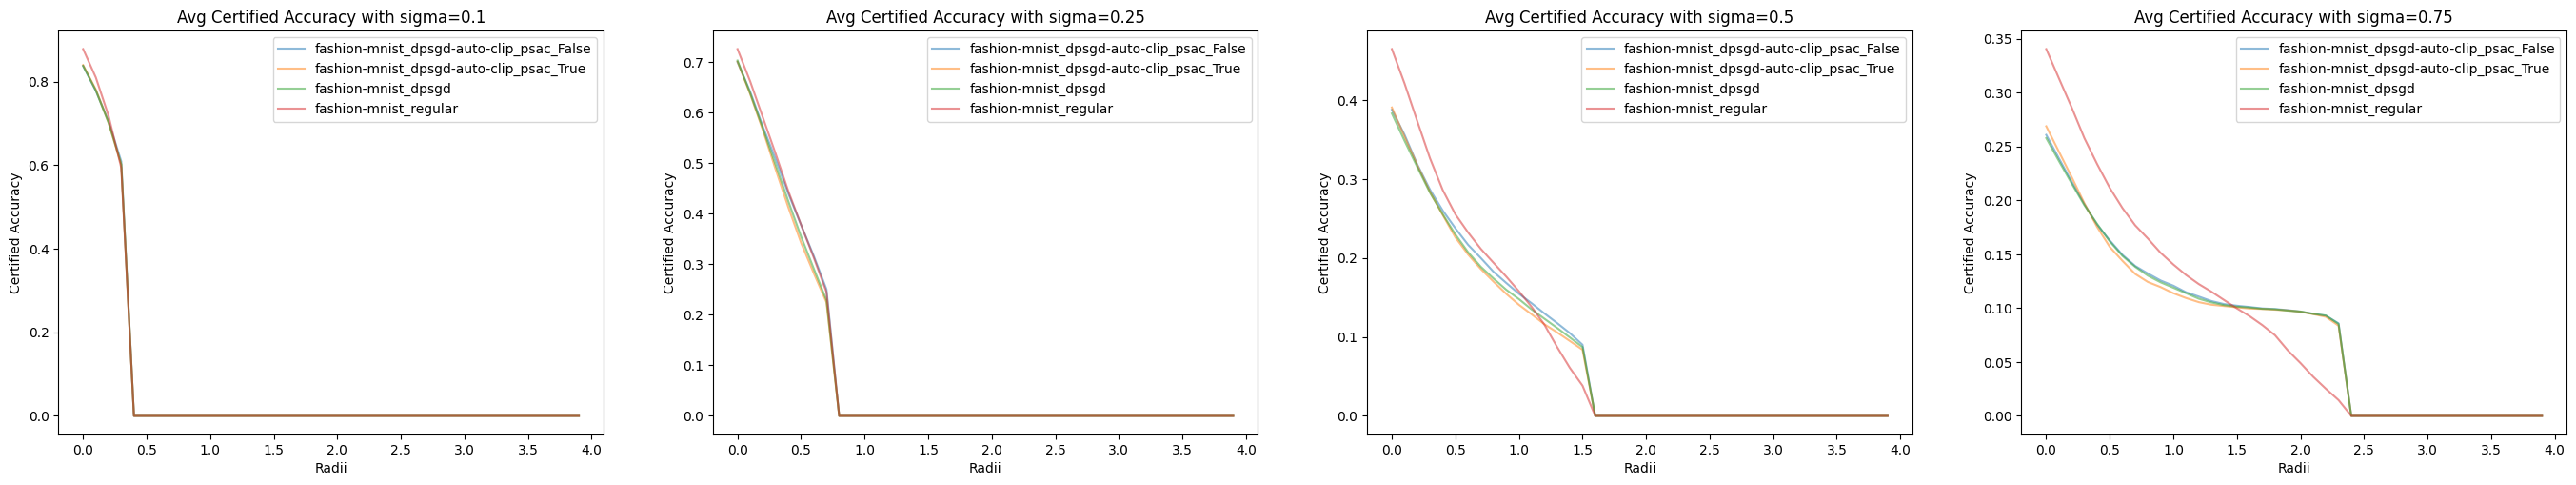

  dataset                      method  accuracy  certified_acc_0.1  certified_acc_0.25  certified_acc_0.5  certified_acc_0.75
3   mnist                     regular    0.9914             0.9904              0.9433             0.4159              0.1633
2   mnist                       dpsgd    0.9811             0.9789              0.9570             0.5010              0.1617
1   mnist  dpsgd-auto-clip_psac_False    0.9803             0.9768              0.8949             0.5429              0.3051
0   mnist   dpsgd-auto-clip_psac_True    0.9800             0.9772              0.8965             0.5141              0.3179


<Figure size 640x480 with 0 Axes>

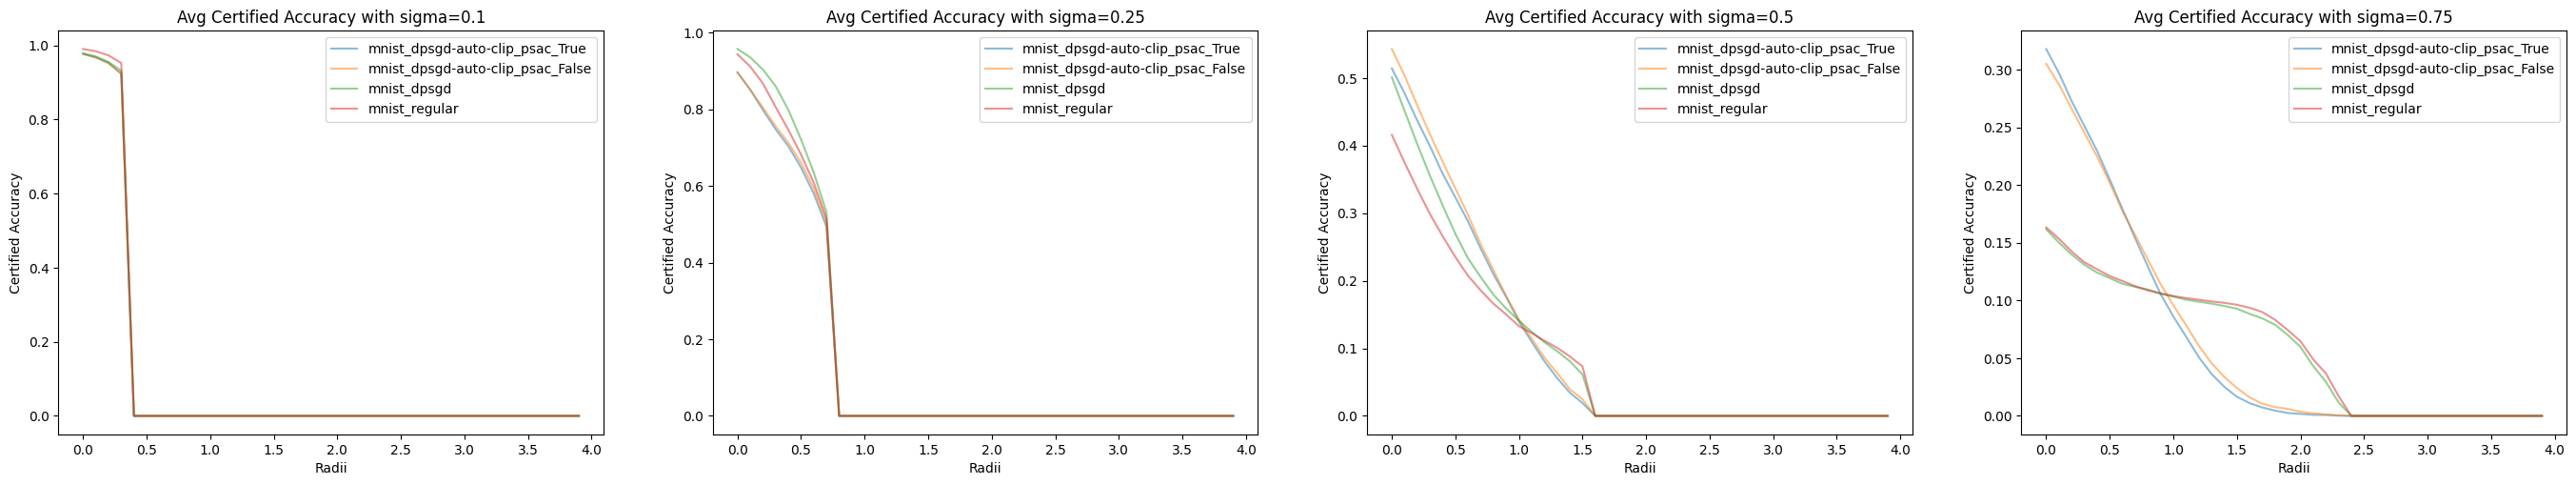

<Figure size 640x480 with 0 Axes>

In [5]:
# comparing regular vs. dp-sgd vs. dp-sgd-auto-clip vs dp-sgd-auto-clip-psac
dir_lists = [
    [
        "fashion-mnist_dpsgd-auto-clip_cnn_sgd_lr_4_bsz_2048_clip_bound_0.1_sigma_2.15Mar30_22-21-57",
        "fashion-mnist_dpsgd-auto-clip_cnn_sgd_lr_4_bsz_2048_clip_bound_0.1_sigma_2.15Mar30_22-22-06",
        "fashion-mnist_dpsgd_cnn_sgd_lr_4_bsz_2048_clip_bound_0.1_sigma_2.15Mar30_22-21-12",
        "fashion-mnist_regular_cnn_sgd_lr_0.01_bsz_512_clip_bound_0.1_sigma_0.8Mar30_22-20-58",
    ],
    [
        "mnist_dpsgd-auto-clip_cnn_sgd_lr_0.5_bsz_512_clip_bound_0.1_sigma_1.23Mar29_18-04-08",
        "mnist_dpsgd-auto-clip_cnn_sgd_lr_0.5_bsz_512_clip_bound_0.1_sigma_1.23Mar29_18-04-21",
        "mnist_dpsgd_cnn_sgd_lr_0.5_bsz_512_clip_bound_0.1_sigma_1.23Mar23_17-57-54",
        "mnist_regular_cnn_sgd_lr_0.01_bsz_512_clip_bound_0.1_sigma_0.8Mar23_17-57-37"
    ]
]
for dir_list in dir_lists:
    test_result_df_dict = {}
    metric_dict = defaultdict(dict)
    key_list = []
    keys_by_noise_std = defaultdict(list)
    keys_by_num_augmentations_noise_std = defaultdict(list)
    keys_by_pgd_steps = defaultdict(list)
    keys_by_max_norm = defaultdict(list)
    for j, dir in enumerate(dir_list):
        
        dir = os.path.join("/data2/paulwu/robust-dp-label-noise/runs", dir)
        with open(os.path.join(dir, "config.json"), "r") as f:
            cfg = json.load(f)
        
        method = cfg['method']
        if cfg['method'] == "dpsgd-auto-clip":
            method += f"_psac_{cfg['psac']}"
        
        cur_key = f"{cfg['dataset']}_{method}"
        key_list.append(cur_key)

        test_result_df = pd.read_json(os.path.join(dir, "test_results.json"))
        test_result_df_dict[cur_key] = test_result_df
        num_correct_at_radius = len(test_result_df[test_result_df['correct'] == True])
        accuracy = num_correct_at_radius / len(test_result_df)
        metric_dict["dataset"][j] = cfg['dataset']
        metric_dict["method"][j] = method
        metric_dict["accuracy"][j] = accuracy
        for sigma in [0.1, 0.25, 0.5, 0.75]:
            radius = test_result_df[f'certified_radius_{sigma}']
            correct = test_result_df[f'certified_correct_{sigma}']
            pred = test_result_df[f'certified_pred_{sigma}']
            certified_accuracy = len(test_result_df[correct == True]) / len(test_result_df)
            # print(sigma, certified_accuracy)
            metric_dict[f"certified_acc_{sigma}"][j] = certified_accuracy

    print(pd.DataFrame(metric_dict).sort_values(by="accuracy", ascending=False).to_string())
    sigma_results = read_certified_robustness_results(key_list, test_result_df_dict)
    fig, ax = plt.subplots(1, 4)
    for i, sigma in enumerate([0.1, 0.25, 0.5, 0.75]):
        for key in key_list:
            avg = pd.DataFrame.from_dict(sigma_results[sigma][key]).iloc[0]
            x = np.arange(0.0, 4, 0.1)
            ax[i].plot(x, avg, alpha=0.5, label=f"{key}")
        ax[i].set_xlabel("Radii")
        ax[i].set_title(f"Avg Certified Accuracy with sigma={sigma}")
        ax[i].set_ylabel("Certified Accuracy")
        ax[i].legend()
    fig.set_size_inches(34, 5.5)
    plt.show()
    plt.clf()

In [46]:
# parameter study for adv_smoothing with different "augment_noise_std", "num_augmentations", "pgd_steps", "max_norm"

dir_list = glob.glob('/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd-adv-smooth_cnn_sgd_lr_0.5_bsz_512_clip_bound_0.1_sigma_1.23_pgd_steps_[24]*Apr1[23]*')
# dir_list = glob.glob('/data2/paulwu/robust-dp-label-noise/runs/fashion-mnist_dpsgd-adv-smooth_cnn_sgd_lr_4_bsz_2048_clip_bound_0.1_sigma_2.15_pgd_steps_[246]*')
test_result_df_dict = {}
metric_dict = defaultdict(dict)
key_list = []
keys_by_noise_std = defaultdict(list)
keys_by_num_augmentations_noise_std = defaultdict(list)
keys_by_pgd_steps = defaultdict(list)
keys_by_max_norm = defaultdict(list)
for dir in dir_list:
    with open(os.path.join(dir, "config.json"), "r") as f:
        cfg = json.load(f)

    augment_noise_std = cfg["augment_noise_std"]
    num_augmentations = cfg['num_augmentations']
    pgd_steps = cfg['pgd_steps']
    max_norm = cfg['max_norm']
    
    method = cfg['method']
    if cfg['method'] == "dpsgd-auto-clip":
        method += f"_psac_{cfg['psac']}"
    
    cur_key = f"noise_std_{augment_noise_std}_num_aug_{num_augmentations}_pgd_steps_{pgd_steps}_max_norm_{max_norm}"
    key_list.append(cur_key)
    keys_by_noise_std[augment_noise_std].append(cur_key)
    keys_by_num_augmentations_noise_std[num_augmentations].append(cur_key)
    keys_by_pgd_steps[pgd_steps].append(cur_key)
    keys_by_max_norm[max_norm].append(cur_key)

    test_result_df = pd.read_json(os.path.join(dir, "test_results.json"))
    test_result_df_dict[cur_key] = test_result_df
    num_correct_at_radius = len(test_result_df[test_result_df['correct'] == True])
    accuracy = num_correct_at_radius / len(test_result_df)
    metric_dict["accuracy"][cur_key] = accuracy
    for sigma in [0.1, 0.25, 0.5, 0.75]:
        radius = test_result_df[f'certified_radius_{sigma}']
        correct = test_result_df[f'certified_correct_{sigma}']
        pred = test_result_df[f'certified_pred_{sigma}']
        certified_accuracy = len(test_result_df[correct == True]) / len(test_result_df)
        # print(sigma, certified_accuracy)
        metric_dict[f"certified_acc_{sigma}"][cur_key] = certified_accuracy


sigma_results = read_certified_robustness_results(key_list, test_result_df_dict)

                                                   accuracy  certified_acc_0.1  certified_acc_0.25  certified_acc_0.5  certified_acc_0.75
noise_std_0.12_num_aug_8_pgd_steps_4_max_norm_64     0.9789             0.9800              0.9668             0.5175              0.1725
noise_std_0.12_num_aug_8_pgd_steps_2_max_norm_64     0.9788             0.9799              0.9669             0.5189              0.1730
noise_std_0.12_num_aug_2_pgd_steps_2_max_norm_64     0.9772             0.9784              0.9597             0.4771              0.1608
noise_std_0.12_num_aug_2_pgd_steps_4_max_norm_64     0.9771             0.9780              0.9595             0.4756              0.1600
noise_std_0.12_num_aug_4_pgd_steps_2_max_norm_64     0.9766             0.9771              0.9664             0.5875              0.2241
noise_std_0.12_num_aug_4_pgd_steps_4_max_norm_64     0.9766             0.9772              0.9663             0.5872              0.2224
noise_std_0.25_num_aug_8_pgd_steps

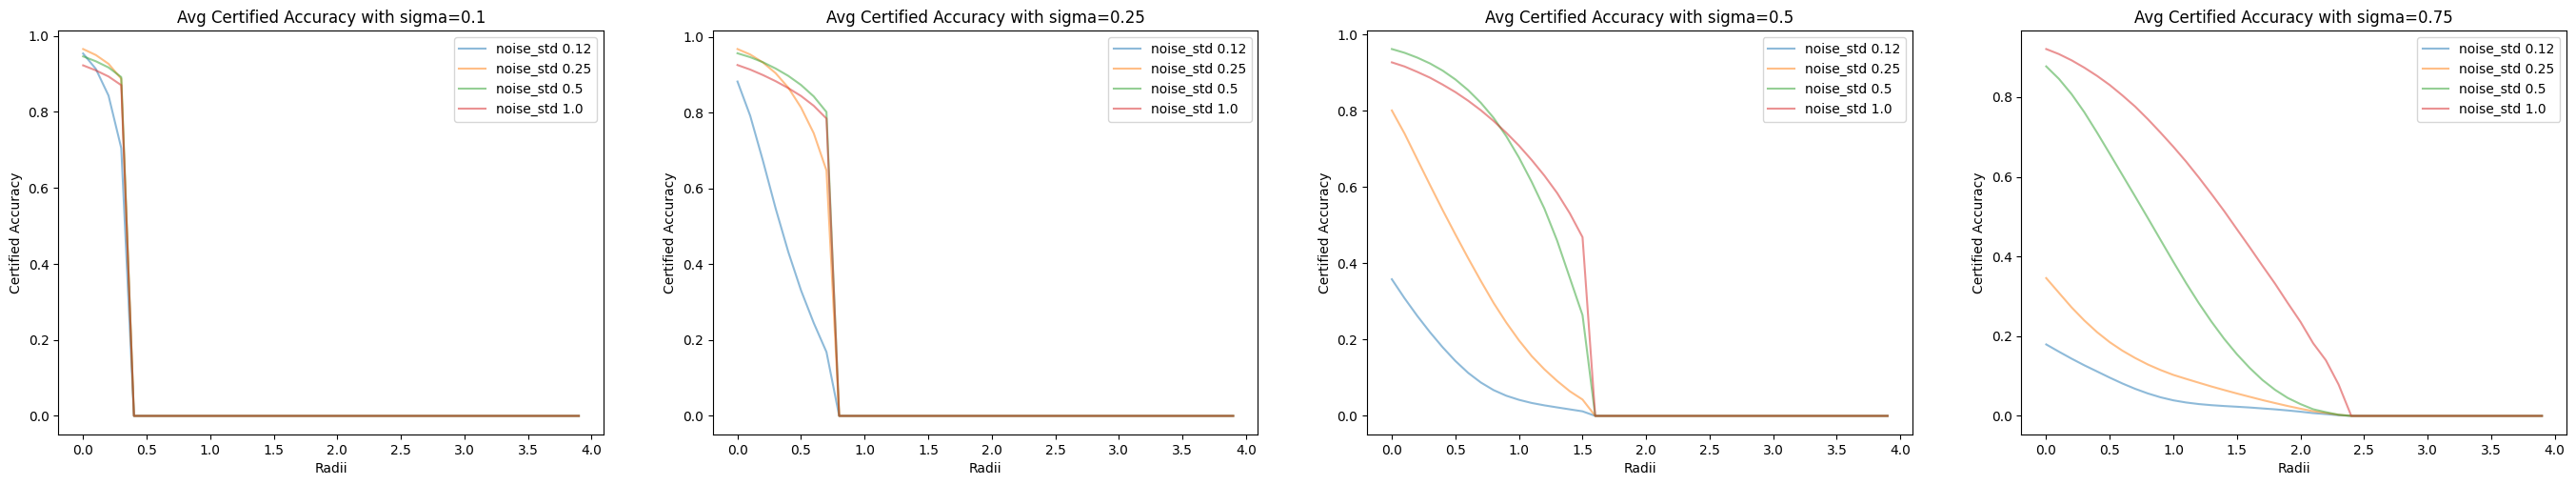

<Figure size 640x480 with 0 Axes>

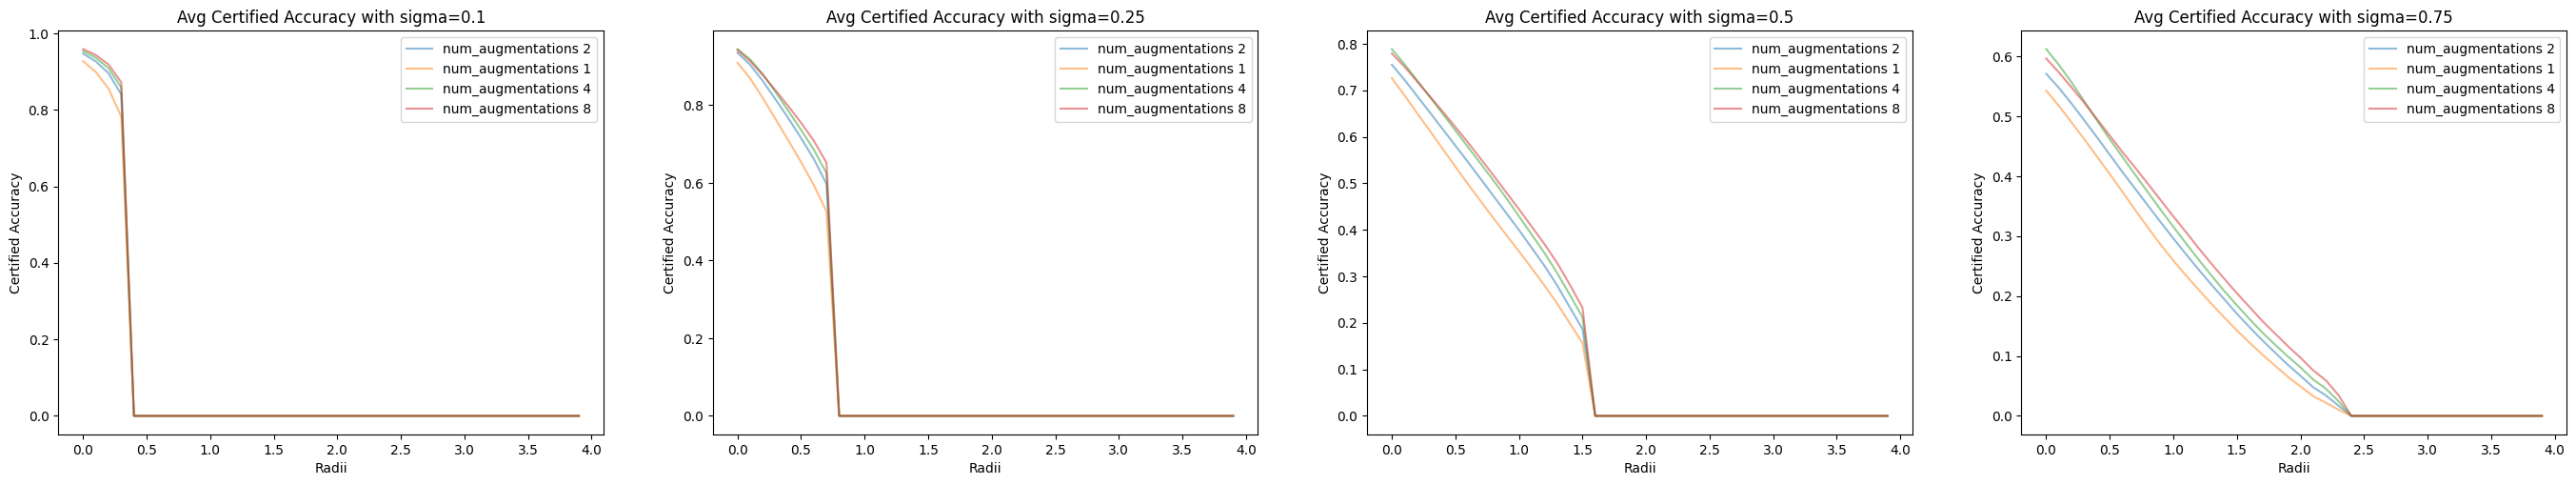

<Figure size 640x480 with 0 Axes>

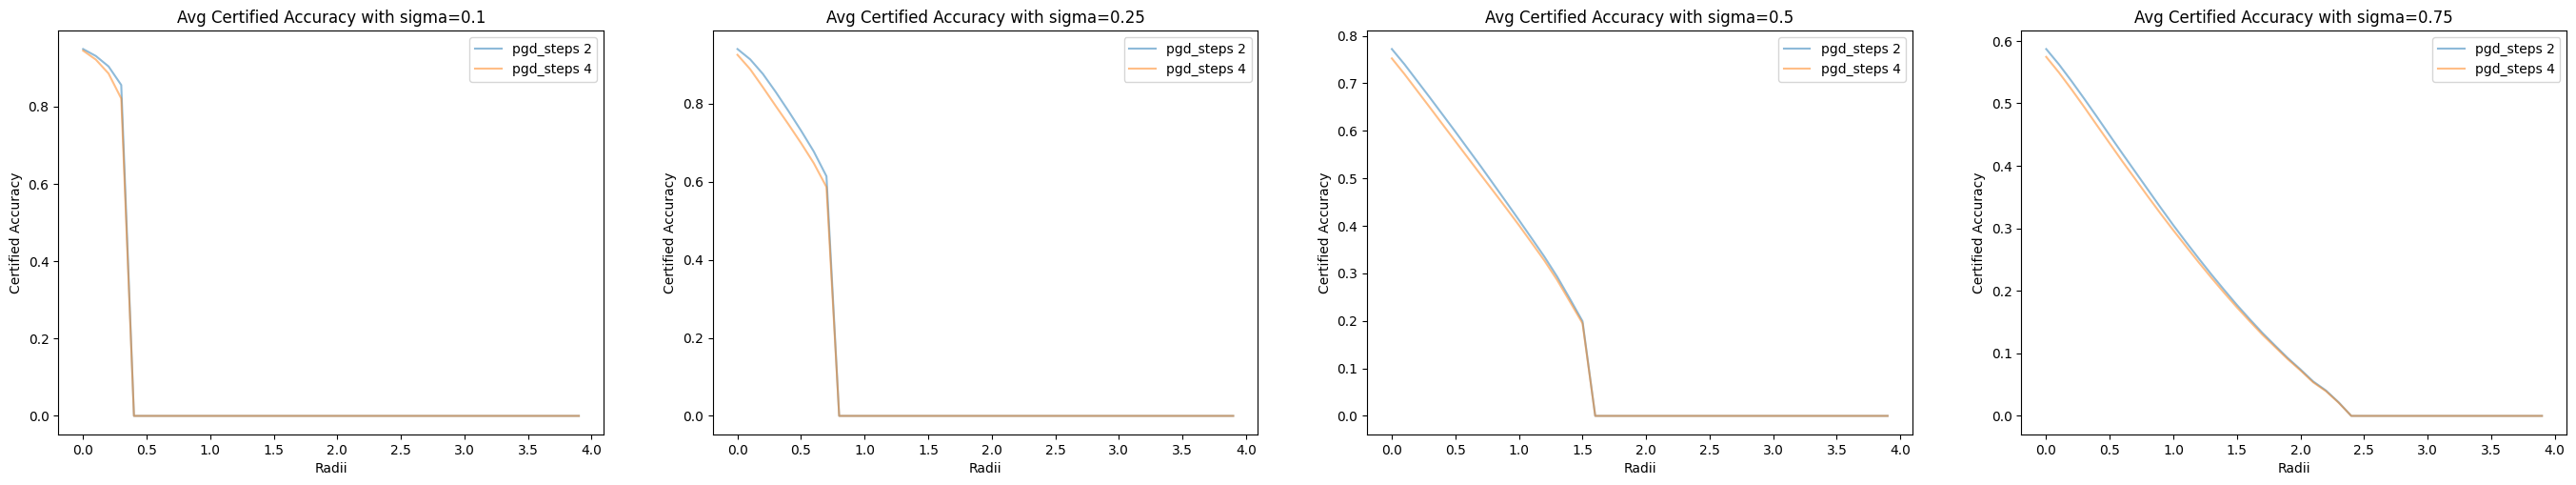

<Figure size 640x480 with 0 Axes>

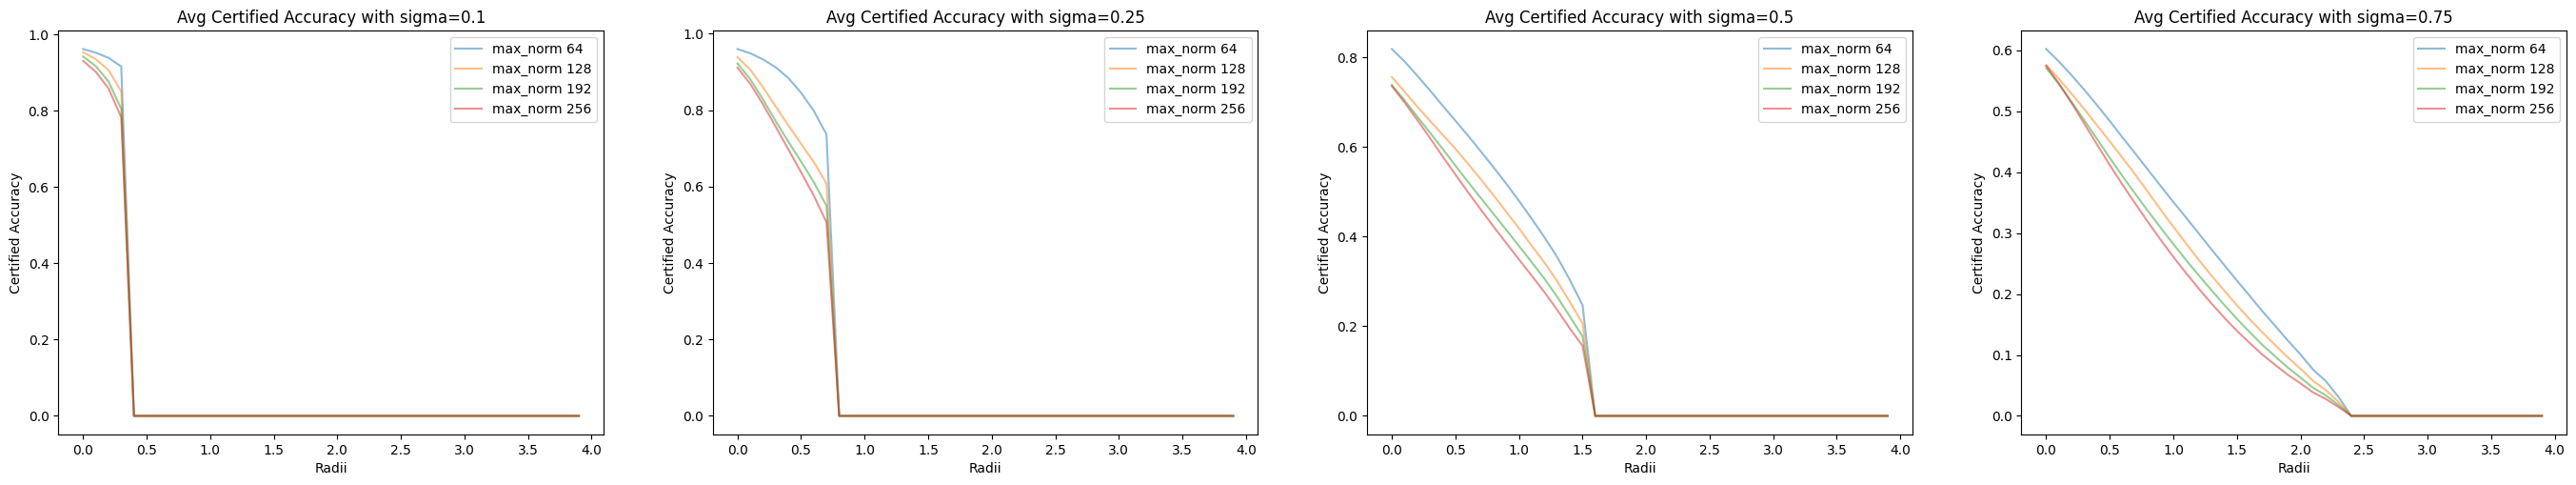

<Figure size 640x480 with 0 Axes>

In [47]:

print(pd.DataFrame(metric_dict).sort_values(by="accuracy", ascending=False).to_string())

for meta_key, key_dict in zip(["noise_std", "num_augmentations", "pgd_steps", "max_norm"],
    [keys_by_noise_std, keys_by_num_augmentations_noise_std, keys_by_pgd_steps, keys_by_max_norm]):
    
    fig, ax = plt.subplots(1, 4)
    for i, sigma in enumerate([0.1, 0.25, 0.5, 0.75]):
        for meta_key_value, key_list in key_dict.items():
            df_list = [pd.DataFrame.from_dict(sigma_results[sigma][key]).iloc[0] for key in key_list]
            # avg the list of dataframes
            avg = pd.concat(df_list, axis=1).mean(axis=1)
            x = np.arange(0.0, 4, 0.1)
            ax[i].plot(x, avg, alpha=0.5, label=f"{meta_key} {meta_key_value}")
        ax[i].set_xlabel("Radii")
        ax[i].set_title(f"Avg Certified Accuracy with sigma={sigma}")
        ax[i].set_ylabel("Certified Accuracy")
        ax[i].legend()
    fig.set_size_inches(34, 5.5)
    plt.show()
    plt.clf()



PSAC = True, dataset = fashion-mnist
         dataset                                method  accuracy  noise_std  num_aug  pgd_steps  max_norm  certified_acc_0.1  certified_acc_0.25  certified_acc_0.5  certified_acc_0.75
1  fashion-mnist  dpsgd-auto-clip-adv-smooth_psac_True    0.7505        1.0        8          2        64             0.7508              0.7511             0.7466              0.7348
3  fashion-mnist  dpsgd-auto-clip-adv-smooth_psac_True    0.7431        1.0        4          2        64             0.7421              0.7436             0.7418              0.7294
0  fashion-mnist  dpsgd-auto-clip-adv-smooth_psac_True    0.7272        1.0        6          2        64             0.7287              0.7315             0.7400              0.7321
2  fashion-mnist  dpsgd-auto-clip-adv-smooth_psac_True    0.6874        1.0        2          2        64             0.6890              0.7002             0.7134              0.7082


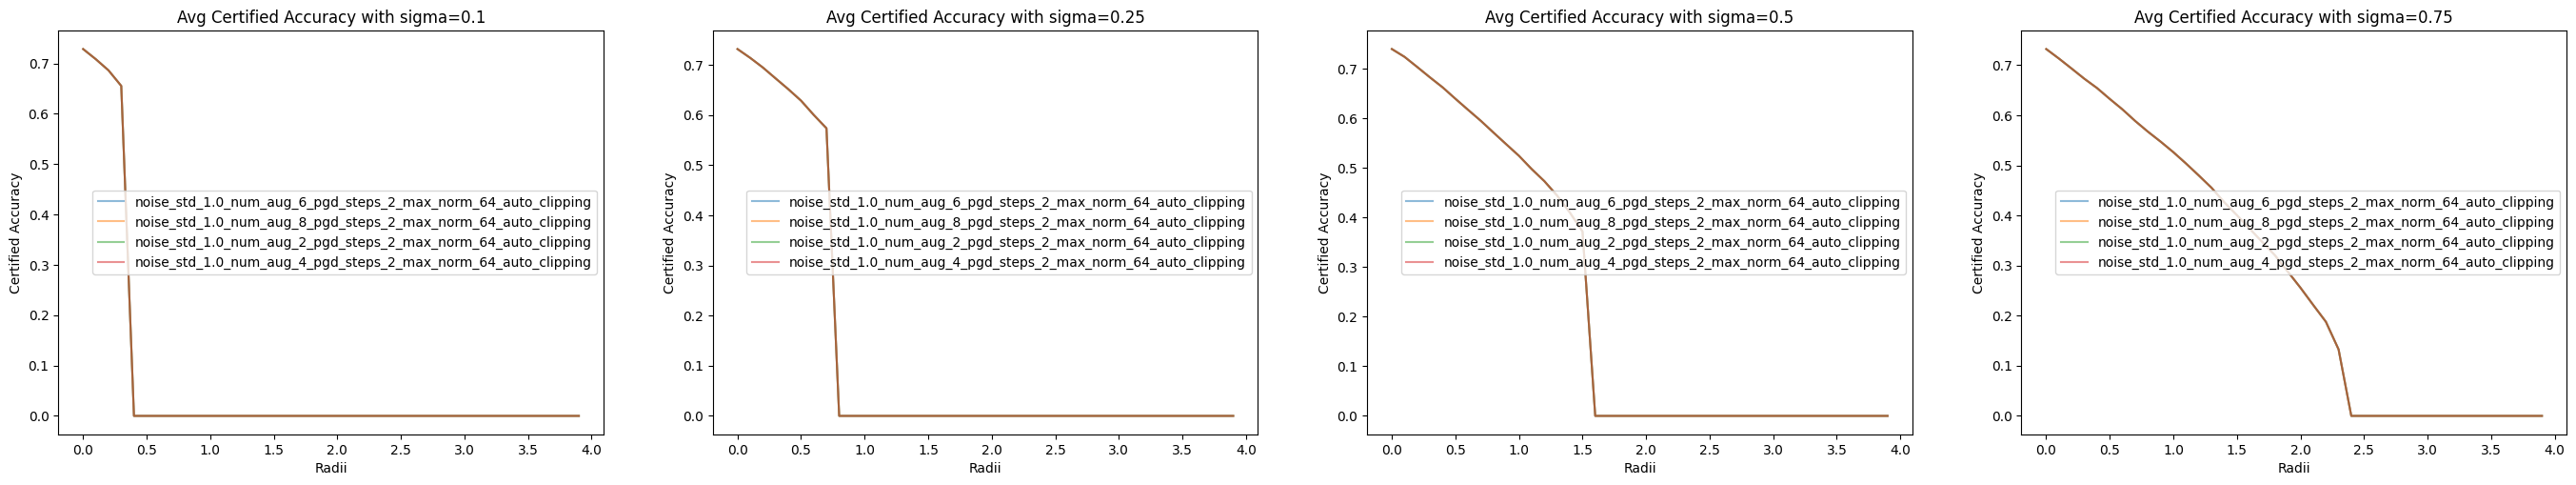

PSAC = False, dataset = fashion-mnist
         dataset                                 method  accuracy  noise_std  num_aug  pgd_steps  max_norm  certified_acc_0.1  certified_acc_0.25  certified_acc_0.5  certified_acc_0.75
0  fashion-mnist  dpsgd-auto-clip-adv-smooth_psac_False    0.7477        1.0        8          2        64             0.7483              0.7471             0.7431              0.7337
3  fashion-mnist  dpsgd-auto-clip-adv-smooth_psac_False    0.7365        1.0        4          2        64             0.7361              0.7366             0.7410              0.7272
1  fashion-mnist  dpsgd-auto-clip-adv-smooth_psac_False    0.7285        1.0        6          2        64             0.7289              0.7327             0.7392              0.7290
2  fashion-mnist  dpsgd-auto-clip-adv-smooth_psac_False    0.6853        1.0        2          2        64             0.6889              0.6975             0.7102              0.7083


<Figure size 640x480 with 0 Axes>

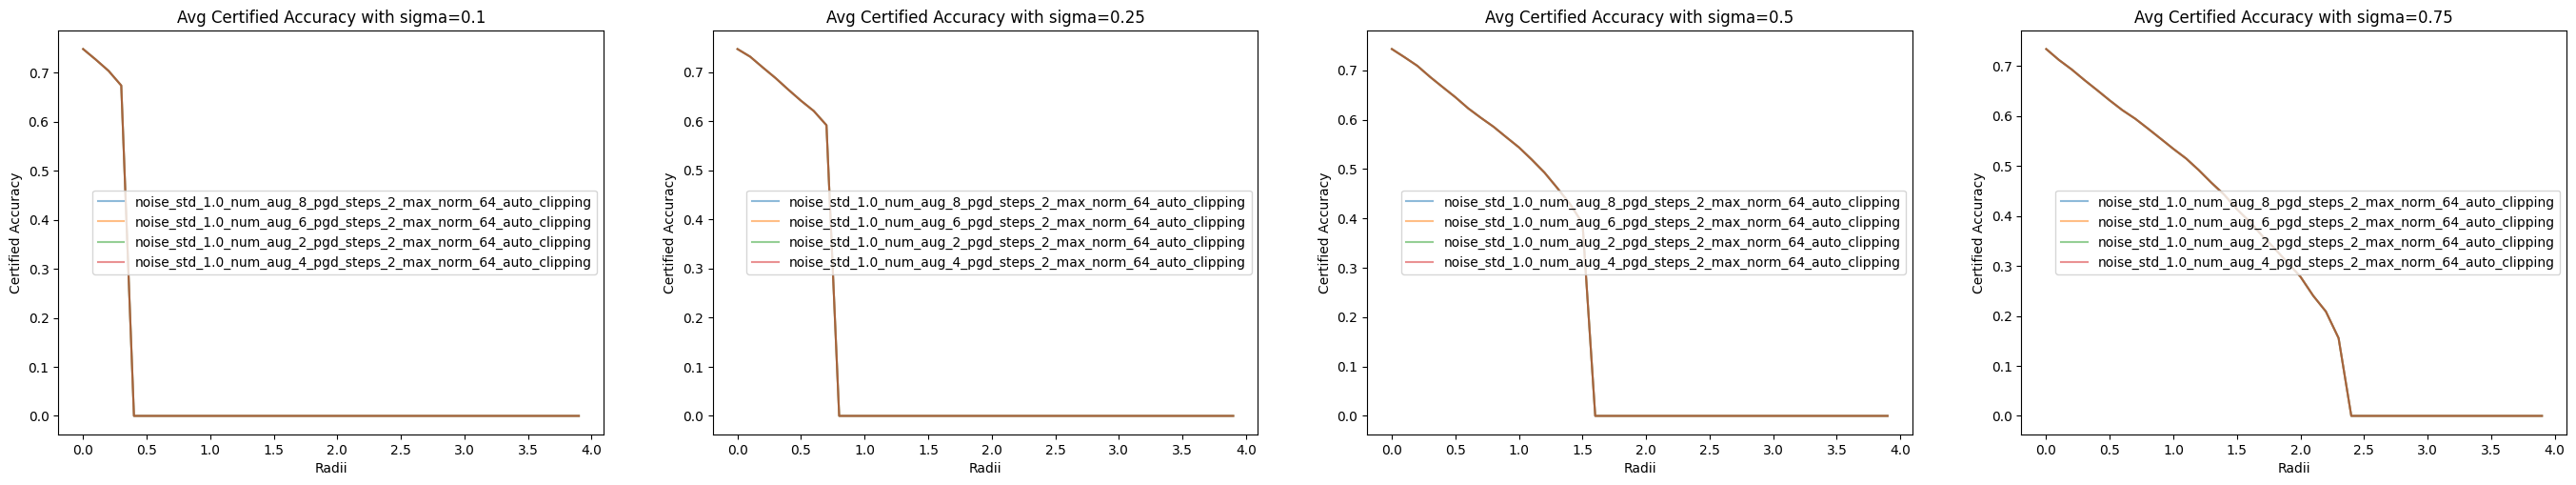

PSAC = True, dataset = mnist
  dataset                                method  accuracy  noise_std  num_aug  pgd_steps  max_norm  certified_acc_0.1  certified_acc_0.25  certified_acc_0.5  certified_acc_0.75
0   mnist  dpsgd-auto-clip-adv-smooth_psac_True    0.9410        1.0        8          2        64             0.9408              0.9403             0.9380              0.9308
3   mnist  dpsgd-auto-clip-adv-smooth_psac_True    0.9406        1.0        6          2        64             0.9401              0.9401             0.9363              0.9294
2   mnist  dpsgd-auto-clip-adv-smooth_psac_True    0.9372        1.0        4          2        64             0.9377              0.9387             0.9361              0.9280
1   mnist  dpsgd-auto-clip-adv-smooth_psac_True    0.9359        1.0        2          2        64             0.9362              0.9366             0.9348              0.9264


<Figure size 640x480 with 0 Axes>

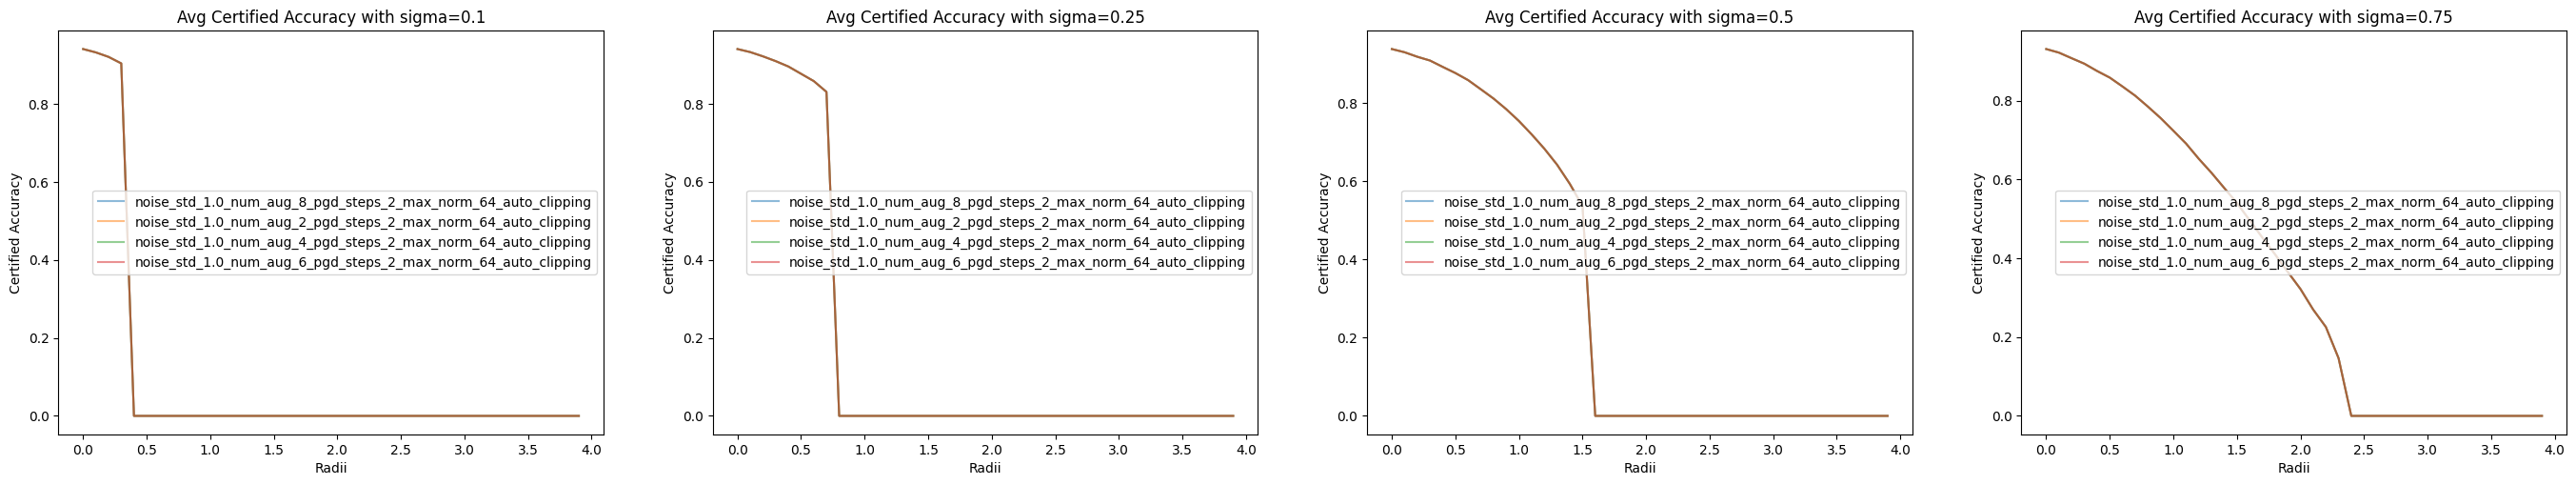

PSAC = False, dataset = mnist
  dataset                                 method  accuracy  noise_std  num_aug  pgd_steps  max_norm  certified_acc_0.1  certified_acc_0.25  certified_acc_0.5  certified_acc_0.75
0   mnist  dpsgd-auto-clip-adv-smooth_psac_False    0.9390        1.0        8          2        64             0.9385              0.9380             0.9353              0.9291
3   mnist  dpsgd-auto-clip-adv-smooth_psac_False    0.9385        1.0        6          2        64             0.9389              0.9377             0.9346              0.9275
1   mnist  dpsgd-auto-clip-adv-smooth_psac_False    0.9349        1.0        2          2        64             0.9350              0.9354             0.9329              0.9248
2   mnist  dpsgd-auto-clip-adv-smooth_psac_False    0.9344        1.0        4          2        64             0.9346              0.9342             0.9335              0.9245


<Figure size 640x480 with 0 Axes>

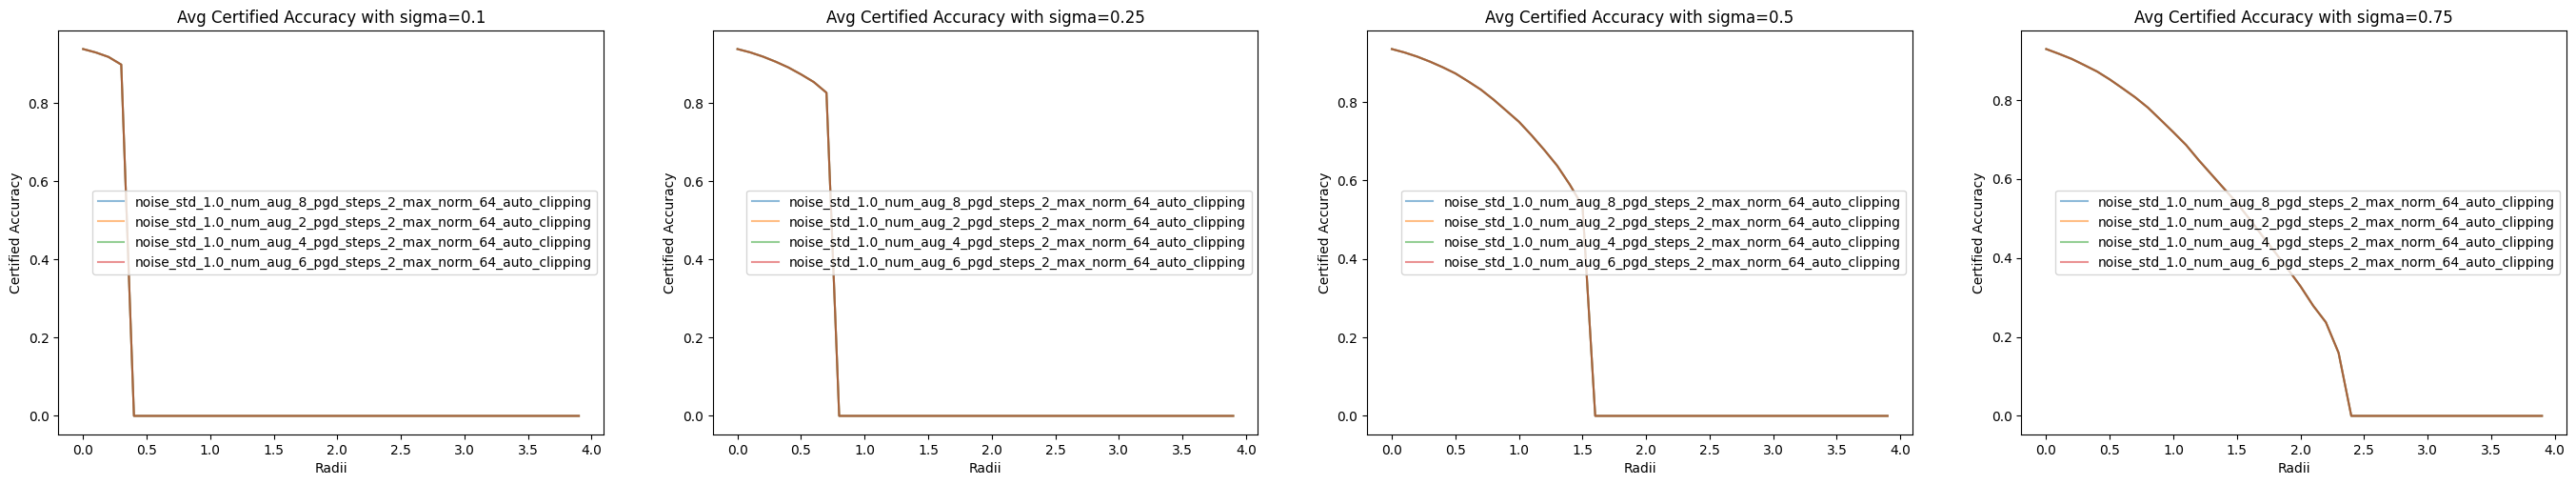

<Figure size 640x480 with 0 Axes>

In [11]:
# adv smoothing with auto clipping
for checkpoint_idx, checkpoint_path in enumerate(["/data2/paulwu/robust-dp-label-noise/runs/fashion-mnist_dpsgd-auto-clip-adv-smooth_cnn_sgd_lr_4_bsz_2048_clip_bound_0.1_sigma_2.15_pgd_steps_2_no_grad_False_max_norm_64_psac", 
                        "/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd-auto-clip-adv-smooth_cnn_sgd_lr_0.5_bsz_512_clip_bound_0.1_sigma_1.23_pgd_steps_2_no_grad_False_max_norm_64_psac"]):
    for psac in [True, False]:
        dataset = {0: 'fashion-mnist', 1: 'mnist'}[checkpoint_idx]
        print(f"PSAC = {psac}, dataset = {dataset}")
        dir_list = glob.glob(f'{checkpoint_path}_{psac}*Apr16*')
        test_result_df_dict = {}
        metric_dict = defaultdict(dict)
        key_list = []
        keys_by_num_augmentations_noise_std = defaultdict(list)
        for j, dir in enumerate(dir_list):
            with open(os.path.join(dir, "config.json"), "r") as f:
                cfg = json.load(f)

            augment_noise_std = cfg["augment_noise_std"]
            num_augmentations = cfg['num_augmentations']
            pgd_steps = cfg['pgd_steps']
            max_norm = cfg['max_norm']
            method = f"{cfg['method']}_psac_{cfg['psac']}"

            metric_dict["dataset"][j] = cfg['dataset']
            metric_dict["method"][j] = method
            metric_dict["accuracy"][j] = accuracy
            metric_dict["noise_std"][j] = augment_noise_std
            metric_dict["num_aug"][j] = num_augmentations
            metric_dict["pgd_steps"][j] = pgd_steps
            metric_dict["max_norm"][j] = max_norm

            cur_key = f"noise_std_{augment_noise_std}_num_aug_{num_augmentations}_pgd_steps_{pgd_steps}_max_norm_{max_norm}_auto_clipping"
            key_list.append(cur_key)
            keys_by_num_augmentations_noise_std[num_augmentations].append(cur_key)

            test_result_df = pd.read_json(os.path.join(dir, "test_results.json"))
            test_result_df_dict[cur_key] = test_result_df
            num_correct_at_radius = len(test_result_df[test_result_df['correct'] == True])
            accuracy = num_correct_at_radius / len(test_result_df)
            metric_dict["accuracy"][j] = accuracy
            for sigma in [0.1, 0.25, 0.5, 0.75]:
                radius = test_result_df[f'certified_radius_{sigma}']
                correct = test_result_df[f'certified_correct_{sigma}']
                pred = test_result_df[f'certified_pred_{sigma}']
                certified_accuracy = len(test_result_df[correct == True]) / len(test_result_df)
                # print(sigma, certified_accuracy)
                metric_dict[f"certified_acc_{sigma}"][j] = certified_accuracy





        print(pd.DataFrame(metric_dict).sort_values(by="accuracy", ascending=False).to_string())
        sigma_results = read_certified_robustness_results(key_list, test_result_df_dict)
        fig, ax = plt.subplots(1, 4)
        for i, sigma in enumerate([0.1, 0.25, 0.5, 0.75]):
            # for meta_key_value, key_list in keys_by_num_augmentations.items():
            for key in key_list:
                avg = pd.DataFrame.from_dict(sigma_results[sigma][key_list[0]]).iloc[0]
                x = np.arange(0.0, 4, 0.1)
                ax[i].plot(x, avg, alpha=0.5, label=f"{key}")
            ax[i].set_xlabel("Radii")
            ax[i].set_title(f"Avg Certified Accuracy with sigma={sigma}")
            ax[i].set_ylabel("Certified Accuracy")
            ax[i].legend()
        fig.set_size_inches(34, 5.5)
        plt.show()
        plt.clf()

/mnt/tmp/ipykernel_3508/1919456164.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heatmap_df[metric] = heatmap_df[metric] * 100
/mnt/tmp/ipykernel_3508/1919456164.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heatmap_df[metric] = heatmap_df[metric] * 100
/mnt/tmp/ipykernel_3508/1919456164.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

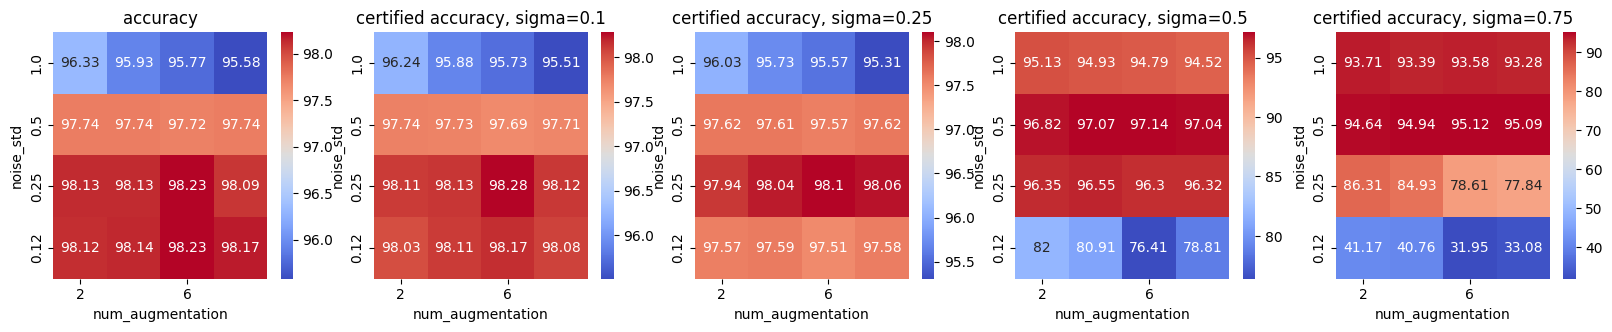

/mnt/tmp/ipykernel_3508/1919456164.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heatmap_df[metric] = heatmap_df[metric] * 100
/mnt/tmp/ipykernel_3508/1919456164.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heatmap_df[metric] = heatmap_df[metric] * 100
/mnt/tmp/ipykernel_3508/1919456164.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

<Figure size 640x480 with 0 Axes>

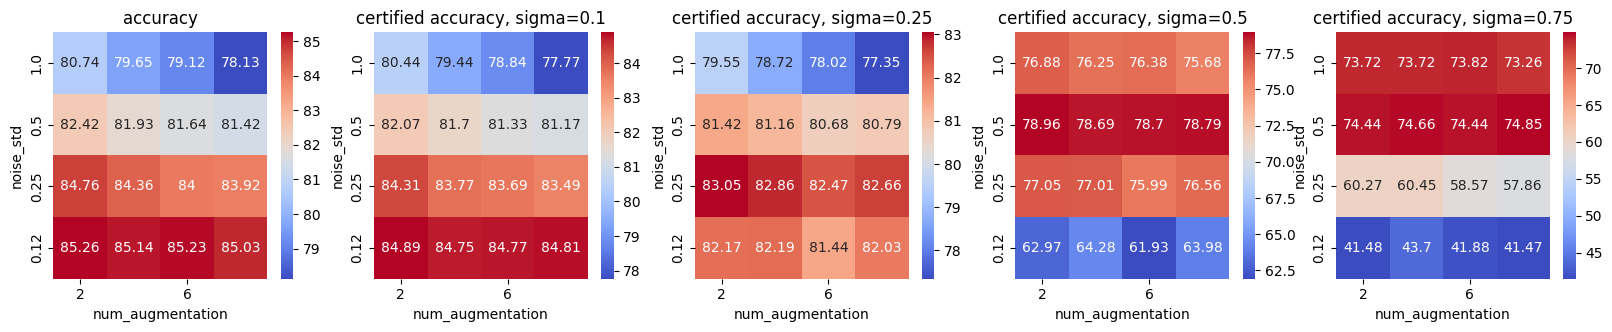

<Figure size 640x480 with 0 Axes>

In [22]:
# dp-augment
for checkpoint_path in ["/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd-augment_cnn_sgd_lr_0.5_bsz_512_clip_bound_0.1_sigma_1.23Apr16*", 
                        "/data2/paulwu/robust-dp-label-noise/runs/fashion-mnist_dpsgd-augment_cnn_sgd_lr_4_bsz_2048_clip_bound_0.1_sigma_2.15Apr16*"]:
    dir_list = glob.glob(checkpoint_path)
    test_result_df_dict = {}
    metric_dict = defaultdict(dict)
    key_list = []
    keys_by_num_augmentations_noise_std = defaultdict(list)
    for j, dir in enumerate(dir_list):
        with open(os.path.join(dir, "config.json"), "r") as f:
            cfg = json.load(f)

        augment_noise_std = cfg["augment_noise_std"]
        num_augmentations = cfg['num_augmentations']
        
        cur_key = f"noise_std_{augment_noise_std}_num_aug_{num_augmentations}"
        key_list.append(cur_key)
        keys_by_num_augmentations_noise_std[num_augmentations].append(cur_key)

        test_result_df = pd.read_json(os.path.join(dir, "test_results.json"))
        test_result_df_dict[cur_key] = test_result_df
        num_correct_at_radius = len(test_result_df[test_result_df['correct'] == True])
        accuracy = num_correct_at_radius / len(test_result_df)

        
        metric_dict["dataset"][j] = cfg['dataset']
        metric_dict["method"][j] = cfg['method']
        metric_dict["accuracy"][j] = accuracy
        metric_dict["noise_std"][j] = augment_noise_std
        metric_dict["num_augmentation"][j] = num_augmentations
        
        for sigma in [0.1, 0.25, 0.5, 0.75]:
            radius = test_result_df[f'certified_radius_{sigma}']
            correct = test_result_df[f'certified_correct_{sigma}']
            pred = test_result_df[f'certified_pred_{sigma}']
            certified_accuracy = len(test_result_df[correct == True]) / len(test_result_df)
            # print(sigma, certified_accuracy)
            metric_dict[f"certified_accuracy_{sigma}"][j] = certified_accuracy
    # print(pd.DataFrame(metric_dict).sort_values(by="accuracy", ascending=False).to_string())
    # sigma_results = read_certified_robustness_results(key_list, test_result_df_dict)

    acc_df = pd.DataFrame(metric_dict).sort_values(by="accuracy", ascending=False)

    sigma_results = read_certified_robustness_results(key_list, test_result_df_dict)

    fig, axes = plt.subplots(1, 5)
    for i, metric in enumerate(["accuracy", "certified_accuracy_0.1", "certified_accuracy_0.25", "certified_accuracy_0.5", "certified_accuracy_0.75"]):
        heatmap_df = acc_df[[metric, "noise_std", "num_augmentation"]]
        heatmap_df[metric] = heatmap_df[metric] * 100
    
        heatmap_data = heatmap_df.pivot(columns="num_augmentation", index="noise_std", values=metric)
        # heatmap_data = heatmap_data[sorted(heatmap_data.index)]
        heatmap_data = heatmap_data.loc[heatmap_data.index.sort_values(ascending=False)]
        # heatmap_data = heatmap_data[sorted(heatmap_data.columns)]
        sns.heatmap(heatmap_data, 
                    annot=True, 
                    cmap="coolwarm",
                    fmt=".4g",
                    # cbar_kws={"label": metric},
                    ax=axes[i]
        )
        if metric == "accuracy":
            axes[i].set_title(metric)
        else:
            metric_split = metric.split("_")
            sigma = metric_split[-1]
            axes[i].set_title(" ".join(metric_split[:-1]) + f", sigma={sigma}")
    
    plt.xticks(rotation=0)
    fig.set_size_inches(20, 3.2)
    # plt.tight_layout()
    plt.show()
    plt.clf()
    
    
    # for meta_key_value, key_list in keys_by_num_augmentations_noise_std.items():
    #     fig, ax = plt.subplots(1, 4)
    #     for i, sigma in enumerate([0.1, 0.25, 0.5, 0.75]):
    #         for key in key_list:
    #             avg = pd.DataFrame.from_dict(sigma_results[sigma][key]).iloc[0]
    #             x = np.arange(0.0, 4, 0.1)
    #             ax[i].plot(x, avg, alpha=0.5, label=f"{key}")
    #         ax[i].set_xlabel("Radii")
    #         ax[i].set_title(f"Avg Certified Accuracy with sigma={sigma}")
    #         ax[i].set_ylabel("Certified Accuracy")
    #         ax[i].legend()
    #     fig.set_size_inches(34, 5.5)
    #     plt.show()
    #     plt.clf()


/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd-adv-smooth*Apr1[78]*


/mnt/tmp/ipykernel_3508/2342906544.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heatmap_df[metric] = heatmap_df[metric] * 100
/mnt/tmp/ipykernel_3508/2342906544.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heatmap_df[metric] = heatmap_df[metric] * 100
/mnt/tmp/ipykernel_3508/2342906544.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

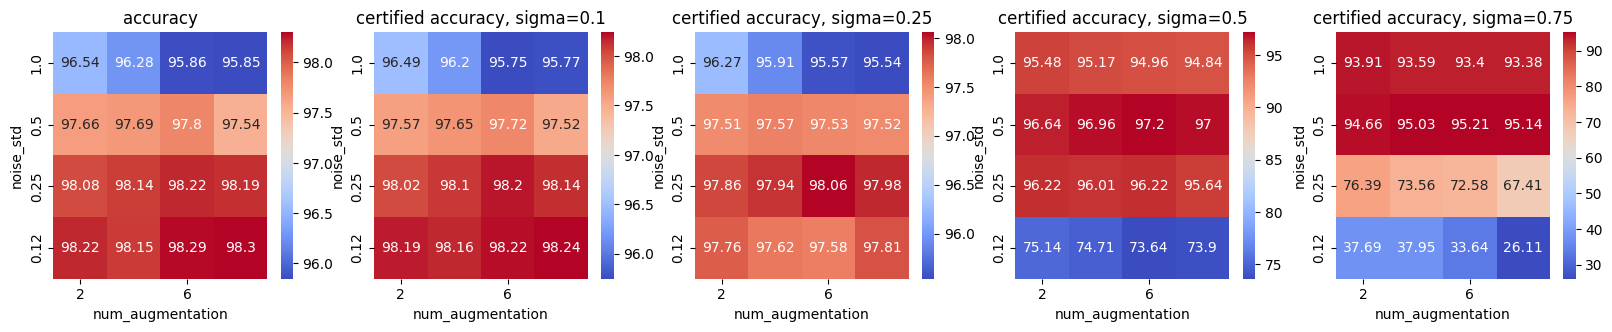

/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd-auto-clip-adv-smooth*psac_True*Apr1[78]*


/mnt/tmp/ipykernel_3508/2342906544.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heatmap_df[metric] = heatmap_df[metric] * 100
/mnt/tmp/ipykernel_3508/2342906544.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heatmap_df[metric] = heatmap_df[metric] * 100
/mnt/tmp/ipykernel_3508/2342906544.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

<Figure size 640x480 with 0 Axes>

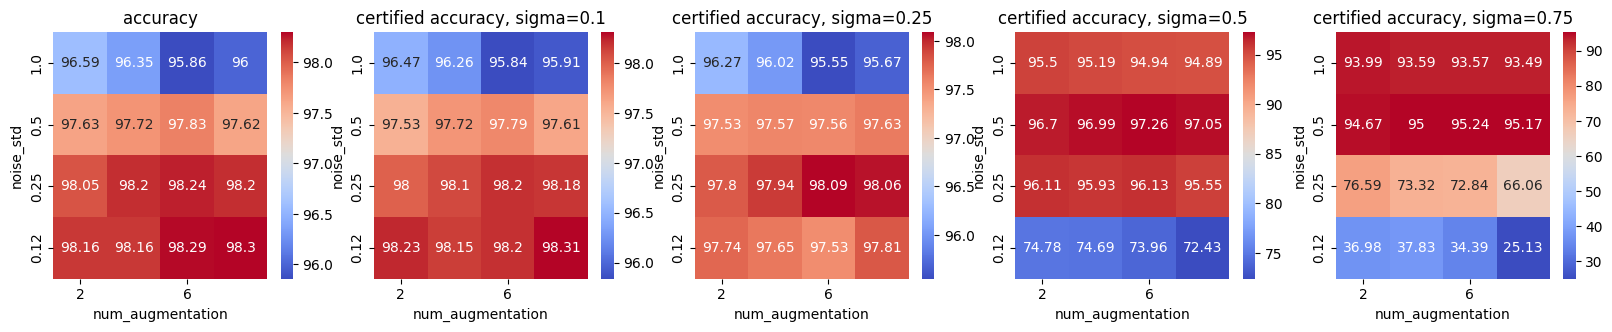

/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd-auto-clip-adv-smooth*psac_False*Apr1[78]*


/mnt/tmp/ipykernel_3508/2342906544.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heatmap_df[metric] = heatmap_df[metric] * 100
/mnt/tmp/ipykernel_3508/2342906544.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heatmap_df[metric] = heatmap_df[metric] * 100
/mnt/tmp/ipykernel_3508/2342906544.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

<Figure size 640x480 with 0 Axes>

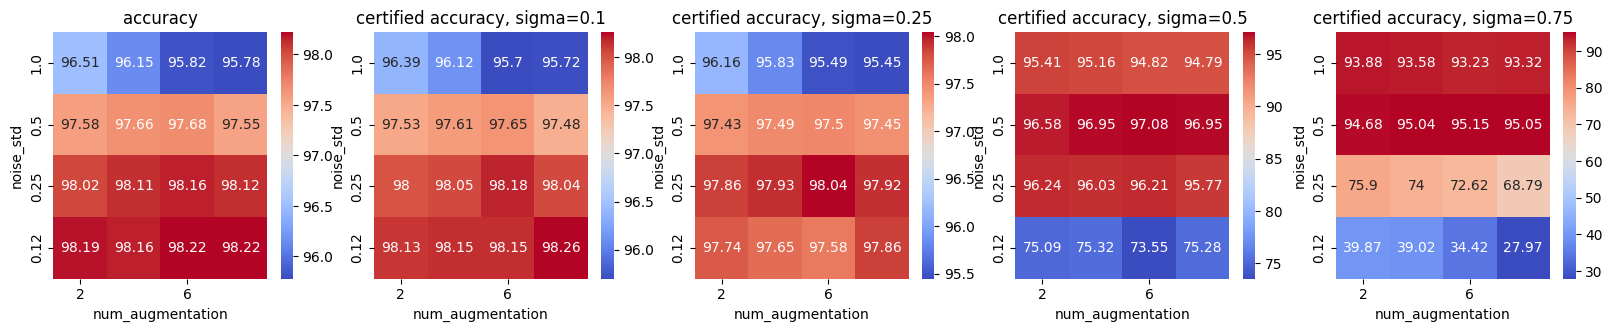

/data2/paulwu/robust-dp-label-noise/runs/fashion-mnist_dpsgd-adv-smooth*Apr1[78]*


/mnt/tmp/ipykernel_3508/2342906544.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heatmap_df[metric] = heatmap_df[metric] * 100
/mnt/tmp/ipykernel_3508/2342906544.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heatmap_df[metric] = heatmap_df[metric] * 100
/mnt/tmp/ipykernel_3508/2342906544.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

<Figure size 640x480 with 0 Axes>

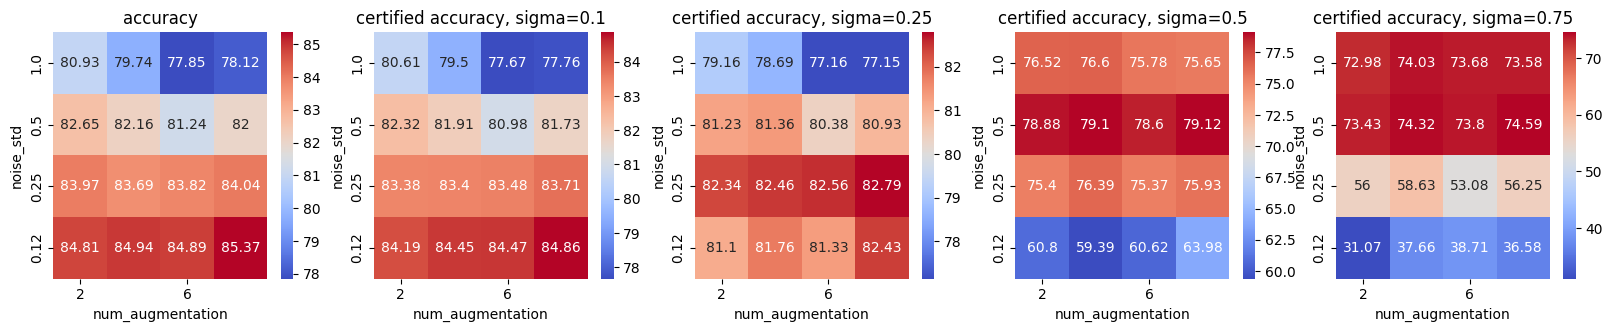

/data2/paulwu/robust-dp-label-noise/runs/fashion-mnist_dpsgd-auto-clip-adv-smooth*psac_True*Apr1[78]*


/mnt/tmp/ipykernel_3508/2342906544.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heatmap_df[metric] = heatmap_df[metric] * 100
/mnt/tmp/ipykernel_3508/2342906544.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heatmap_df[metric] = heatmap_df[metric] * 100
/mnt/tmp/ipykernel_3508/2342906544.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

<Figure size 640x480 with 0 Axes>

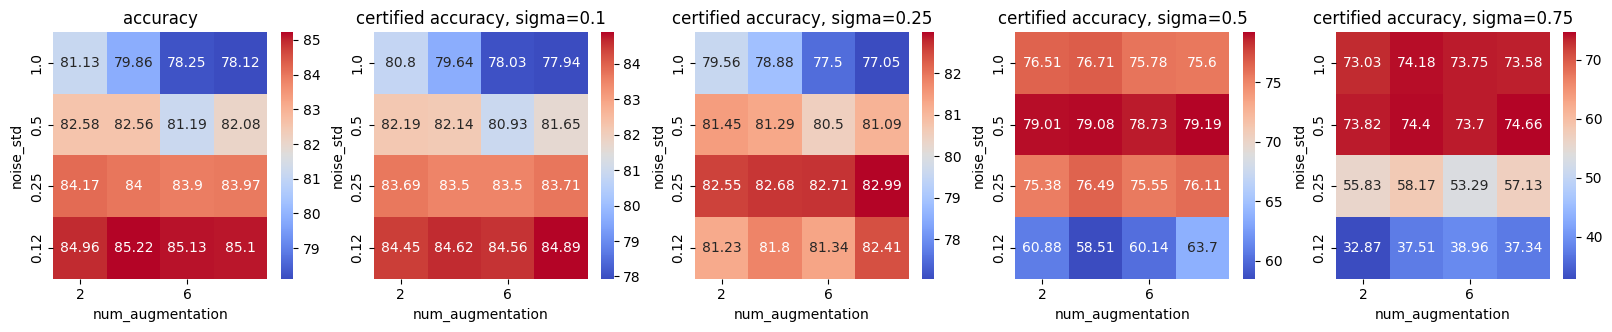

/data2/paulwu/robust-dp-label-noise/runs/fashion-mnist_dpsgd-auto-clip-adv-smooth*psac_False*Apr1[78]*


/mnt/tmp/ipykernel_3508/2342906544.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heatmap_df[metric] = heatmap_df[metric] * 100
/mnt/tmp/ipykernel_3508/2342906544.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heatmap_df[metric] = heatmap_df[metric] * 100
/mnt/tmp/ipykernel_3508/2342906544.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

<Figure size 640x480 with 0 Axes>

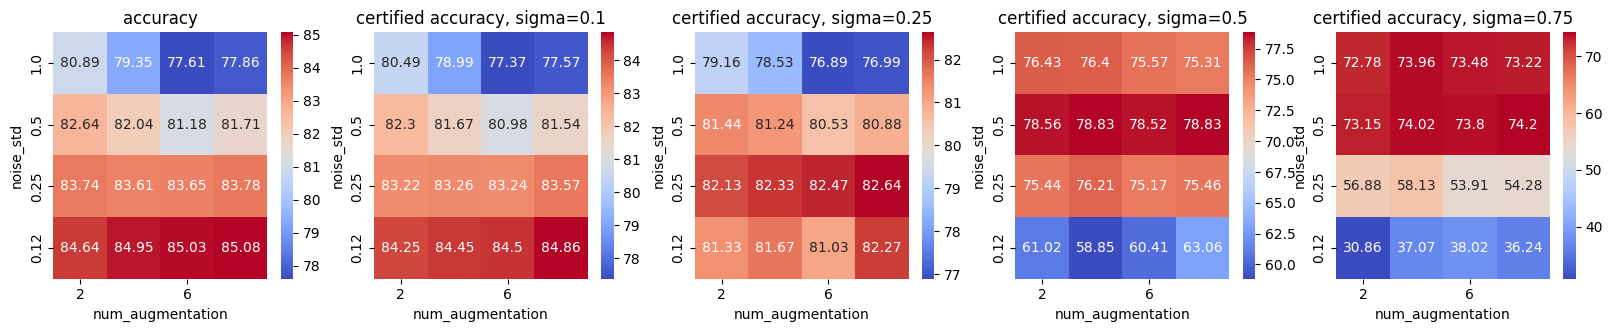

<Figure size 640x480 with 0 Axes>

In [21]:
checkpoint_paths = [
    '/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd-adv-smooth*Apr1[78]*',
    '/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd-auto-clip-adv-smooth*psac_True*Apr1[78]*',
    '/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd-auto-clip-adv-smooth*psac_False*Apr1[78]*',
    '/data2/paulwu/robust-dp-label-noise/runs/fashion-mnist_dpsgd-adv-smooth*Apr1[78]*',
    '/data2/paulwu/robust-dp-label-noise/runs/fashion-mnist_dpsgd-auto-clip-adv-smooth*psac_True*Apr1[78]*',
    '/data2/paulwu/robust-dp-label-noise/runs/fashion-mnist_dpsgd-auto-clip-adv-smooth*psac_False*Apr1[78]*',
]
for checkpoint_path in checkpoint_paths:
    print(checkpoint_path)
    dir_list = glob.glob(checkpoint_path)
    # print(dir_list)
    test_result_df_dict = {}
    metric_dict = defaultdict(dict)
    key_list = []
    keys_by_num_augmentations_noise_std = defaultdict(list)
    for j, dir in enumerate(dir_list):
        # print(dir)
        with open(os.path.join(dir, "config.json"), "r") as f:
            cfg = json.load(f)
        
        method = cfg['method']
        if cfg['method'] == "dpsgd-auto-clip-adv-smooth":
            method += f"_psac_{cfg['psac']}"
        augment_noise_std = cfg["augment_noise_std"]
        num_augmentations = cfg['num_augmentations']

        cur_key = f"{cfg['dataset']}_{method}_noise_std_{augment_noise_std}_num_aug_{num_augmentations}"
        key_list.append(cur_key)
        keys_by_num_augmentations_noise_std[f"{num_augmentations}_{augment_noise_std}"].append(cur_key)

        test_result_df = pd.read_json(os.path.join(dir, "test_results.json"))
        test_result_df_dict[cur_key] = test_result_df
        num_correct_at_radius = len(test_result_df[test_result_df['correct'] == True])
        accuracy = num_correct_at_radius / len(test_result_df)

        metric_dict["dataset"][j] = cfg['dataset']
        metric_dict["method"][j] = method
        metric_dict["noise_std"][j] = augment_noise_std
        metric_dict["num_augmentation"][j] = num_augmentations
        metric_dict["accuracy"][j] = accuracy
        # print(accuracy)
        for sigma in [0.1, 0.25, 0.5, 0.75]:
            radius = test_result_df[f'certified_radius_{sigma}']
            correct = test_result_df[f'certified_correct_{sigma}']
            pred = test_result_df[f'certified_pred_{sigma}']
            certified_accuracy = len(test_result_df[correct == True]) / len(test_result_df)
            metric_dict[f"certified_accuracy_{sigma}"][j] = certified_accuracy
    acc_df = pd.DataFrame(metric_dict).sort_values(by="accuracy", ascending=False)

    sigma_results = read_certified_robustness_results(key_list, test_result_df_dict)

    fig, axes = plt.subplots(1, 5)
    for i, metric in enumerate(["accuracy", "certified_accuracy_0.1", "certified_accuracy_0.25", "certified_accuracy_0.5", "certified_accuracy_0.75"]):
        heatmap_df = acc_df[[metric, "noise_std", "num_augmentation"]]
        heatmap_df[metric] = heatmap_df[metric] * 100
    
        heatmap_data = heatmap_df.pivot(columns="num_augmentation", index="noise_std", values=metric)
        # heatmap_data = heatmap_data[sorted(heatmap_data.index)]
        heatmap_data = heatmap_data.loc[heatmap_data.index.sort_values(ascending=False)]
        # heatmap_data = heatmap_data[sorted(heatmap_data.columns)]
        
        # heatmap_data = heatmap_data[sorted(heatmap_data.columns)]
        sns.heatmap(heatmap_data, 
                    annot=True, 
                    cmap="coolwarm",
                    fmt=".4g",
                    # cbar_kws={"label": metric},
                    ax=axes[i]
        )
        if metric == "accuracy":
            axes[i].set_title(metric)
        else:
            metric_split = metric.split("_")
            sigma = metric_split[-1]
            axes[i].set_title(" ".join(metric_split[:-1]) + f", sigma={sigma}")

    
    plt.xticks(rotation=0)
    fig.set_size_inches(20, 3.2)
    plt.show()
    plt.clf()

    # fig, ax = plt.subplots(1, 4)
    # for i, sigma in enumerate([0.1, 0.25, 0.5, 0.75]):
    #     for key in key_list:
    #         avg = pd.DataFrame.from_dict(sigma_results[sigma][key]).iloc[0]
    #         x = np.arange(0.0, 4, 0.1)
    #         ax[i].plot(x, avg, alpha=0.5, label=f"{key}")
    #     ax[i].set_xlabel("Radii")
    #     ax[i].set_ylabel("Certified Accuracy")
    #     ax[i].set_title(f"Avg Certified Accuracy with sigma={sigma}")
    #     ax[i].legend()
    # fig.set_size_inches(34, 5.5)
    # plt.show()
    # plt.clf()

